# **Project Overview** 
<br>
<b>Business Problem</b>: <br>Question from Airbnb Hosts: <br>Will my listing be popular and reach a high booking rate? 
<br><br> 
<b>Objective</b>: <br>Predict the popularity of airbnb listing using number of reviews based on listing attributes.

# **1. Data Cleansing**

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing base library
import pandas as pd 
import numpy as np 
from datetime import date, datetime, timedelta
import time

# Importing library for ploting
import seaborn as sns 
import matplotlib.pyplot as plt
import urllib
from wordcloud import WordCloud, STOPWORDS

# Importing library for pre-processing
import math
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Importing library for models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

In [4]:
#Start Time Count
Start_time = time.time()

## **1.1 Importing and Validating Dataset**

In [5]:
# Import the external .csv file.
# Assumption: The .csv file is put together with the .ipynb file.
bnb = pd.read_csv(r"AB_NYC_2019.csv")

# Retrieving the first 5 rows of the dataset.
bnb.head(5)

FileNotFoundError: [Errno 2] File b'AB_NYC_2019.csv' does not exist: b'AB_NYC_2019.csv'

In [ ]:
# Retrieving the last 5 rows of the dataset.
bnb.tail()

48895 rows x 16 columns in total (first row index 0)

In [ ]:
# Getting some basic statistical details of the dataset.
bnb.describe()

In [ ]:
# Data Exploration and Visualization.
# Getting the columns of the dataset.
print("Columns: \n", bnb.columns, "\n")

# Getting the dimensions of the dataset.
print("Dimension: ", bnb.shape)

## **1.2 Checking for duplicates and remove unrelated columns** 

In [ ]:
# Checking the duplicate rows based on ID.
print('No of listings excluding duplicated record):',bnb['id'].unique().size)
print('Total listings:', bnb['id'].size)

There are no duplicate rows to handle.

## **1.3 Checking Missing Values**

In [ ]:
# Finding missing values by comparing number of non-null values.
bnb.info()

"name", "last_review", "reviews_per_month" contain null values and need to be processed.

The attribute "host_name" is NOT being processed because the attribute "host_id" is representating a unique host.

In [ ]:
# Finding the exact number of missing values.
bnb.isnull().sum()

In [ ]:
bnb['last_review'] = pd.to_datetime(bnb['last_review'], infer_datetime_format=True)
total = bnb.isnull().sum().sort_values(ascending=False) 
percent=(bnb.isnull().sum()/bnb.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent']).sort_values('Total', ascending=False)
missing_data

Thus, 16 "name", 10052 "last_review", and 10052 "reviews_per_month" are needed to be processed.

## **1.4 Preprocessing columns**

### **1.4.1 Processing columns with missing or null values**

**1.4.1.1 Processing "name" column**

In [ ]:
# Checking for missing values.
bnb[bnb["name"].isnull()]

There are 16 rows with NaN values. Since the 16 rows provide limited information for the other columns, they are most likely fake listing and are not useful for data analysis. So, we decided to drop them.

In [ ]:
# Dropping rows with missing "name" values.
bnb = bnb.dropna(subset=["name"])
bnb

16 rows are removed. Now we have (48895 - 16 = ) 48,879 rows.

**1.4.1.2 Processing "host_name" column**

In [ ]:
# Checking for missing values.
bnb[bnb["host_name"].isnull()]

There are 21 rows with NaN values. Since the 21 rows provide limited information for the other columns, they are most likely fake listing and are not useful for data analysis. So, we decided to drop them.

In [ ]:
# Dropping rows with missing "host_name" values.
bnb = bnb.dropna(subset=["host_name"])
bnb

21 rows are removed. Now we have (48879 - 21 = ) 48858 rows.

**1.4.1.3 Processing "last_review" and "reviews_per_month" column**

We found that the number of rows which contains NaN are the same between attribute "last_review" and "reviews_per_month".

In [ ]:
# Checking for missing values in "last_review" column.
bnb[bnb["last_review"].isnull()]

In [ ]:
# Checking for missing values in reviews_per_month column.
bnb[bnb["reviews_per_month"].isnull()]

The verification is as follows:

In [ ]:
(bnb["last_review"].isnull() == bnb["reviews_per_month"].isnull()).all()

We analyze that when "last_review" is NaN, so is "reviews_per_month". There are 10042 rows with NaN values in both columns. 

We considered replacing the NaN value with a mean/mode/random date, yet it is not quite reasonable to create further noise to our predictive model. Hence, our decision is to drop all the rows with value NaN in either attribute "last_review" or "reviews_per_month".

In [ ]:
# Trying to drop all the rows with value NaN in column "last_review".
bnb = bnb.dropna(subset=["last_review"])
bnb

In [ ]:
# Trying to drop all the rows with value NaN in column "reviews_per_month".
bnb = bnb.dropna(subset=["reviews_per_month"])
bnb

Therefore, there are (48879 - 10042 = ) 38837 rows left.

**1.4.1.3 Post-processing**

The checking after processing observable missing or NaN attributes:

In [ ]:
bnb['last_review'] = pd.to_datetime(bnb['last_review'], infer_datetime_format=True)
total = bnb.isnull().sum().sort_values(ascending=False) 
percent=(bnb.isnull().sum()/bnb.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent']).sort_values('Total', ascending=False)
missing_data

In [ ]:
bnb.info()

Thus, the process is finished.

### **1.4.2 Processing "availability_365" column**

In [ ]:
# Checking for values = 0 in column "availability_365".
bnb.loc[bnb["availability_365"] == 0]

There are 12684 rows with 0. Since they provide useful information in other columns, we will replace them with mean.

In [ ]:
# Replacing the null rows with the mean.
bnb["availability_365"].replace(0, bnb["availability_365"].mean(), inplace = True)
bnb

# **2. Exploratory Data Analysis (EDA)**

Before moving on to data construction, we would first like to do some visualization of the current data to better understand the dataset.

## **2.1: Pie chart displaying the distribution of listings across neighbourhood groups**

In [ ]:
%matplotlib inline
plt.figure(figsize=(8,8)) 
bnb.groupby("neighbourhood_group").neighbourhood_group.count().sort_values().plot(kind="pie") 
labels = list(bnb['neighbourhood_group'].unique())
sizes = list(bnb.groupby("neighbourhood_group").neighbourhood_group.count().sort_values())

plt.title("Neighbourhood distribution")
plt.pie(sizes,autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.3)
plt.ylabel("")

This chart shows the distribution of listings across the five neighborhood groups in NYC. We can see that the neighborhood group with the highest number of listings is Manhattan, followed by Brooklyn, Queens, Bronx and Staten Island. Manhattan and Brooklyn has most listings by far, having 85% of listings in these two neighborhood groups.

## **2.2: Pie chart showing the distribution of room types**

In [ ]:
%matplotlib inline
plt.figure(figsize=(8,8)) 
bnb.groupby("room_type").room_type.count().sort_values().plot(kind="pie")
labels = list(bnb['room_type'].unique())
sizes = list(bnb.groupby("room_type").room_type.count().sort_values())

plt.title("Room type distribution")
plt.pie(sizes,autopct='%1.1f%%', pctdistance=0.9, labeldistance=1.3)
plt.ylabel("")

This pie chart shows the distribution of room types, with entire home or apartment the most popular room type (52%), followed by private room, a close second (45.7%). Shared room has a significantly lower popularity of only 2.4%.

## **2.3: Catplot displaying the relationship between neighbourhood and room type**

In [ ]:
# Finding out top 10 neighbourhoods
print(bnb.neighbourhood.value_counts().head(10))

# Constructing a sub-dataframe for top 10 neighbourhood
sub_1 = bnb.loc[bnb['neighbourhood'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem','Bushwick',
                 'Upper West Side','Hell\'s Kitchen','East Village','Upper East Side','Crown Heights','Midtown'])]

# Constructing the catplot
viz_3 = sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=sub_1, kind='count')
viz_3.set_xticklabels(rotation=90)

"Shared room" type Airbnb listing is not available among 10 most listing-populated neighborhoods. The top ten neighbourhoods lies within Manhattan and Brooklyn. As they are one of the most traveled destinations, they would have the most listing availability. We can also see that Bedford-Stuyvesant and Williamsburg are the most popular for Brooklyn borough, and Harlem and Upper East Side for Manhattan.

## **2.4: Scatterplot displaying the relationship between neighbourhood and number of reviews**

In [ ]:
bnb['number_of_reviews'].describe()

In [ ]:
# Creating a sub-dataframe with no extreme values in number of reviews
sub_1 = bnb[bnb.number_of_reviews < 100]

# Initializing the figure size
plt.figure(figsize = (10,8))

# Loading the png NYC image found on Google
nycimage = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG")
read_nycimage = plt.imread(nycimage)

# Scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(read_nycimage, zorder = 0,extent = [-74.258, -73.7, 40.49, 40.92])
ax = plt.gca()

# Constructing the scatterplot
sub_1.plot(kind = "scatter", x = "longitude", y = "latitude", label = "Listings", c = "number_of_reviews", ax = ax, 
           cmap = plt.get_cmap("jet"), colorbar = True, alpha = 0.4, zorder = 5)
plt.legend()
plt.show()

The insight we can draw from this chart is that areas with more airbnb listings seem to have a lower number of reviews. Areas with less listing density have more listings with higher number of reviews (as shown by the lighter color circles). This implies that the more listings in an area, the lower the popularity in terms of number of reviews.

## **2.5: Scatterplot displaying the relationship between neighbourhood and price**

In [ ]:
# Creating a sub-dataframe with no extreme values in price
sub_2 = bnb[bnb.price < 500]

# Initializing the figure size
plt.figure(figsize = (10,8))

# Loading the png NYC image found on Google
nycimage = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG")
read_nycimage = plt.imread(nycimage)

# Scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(read_nycimage, zorder = 0,extent = [-74.258, -73.7, 40.49, 40.92])
ax = plt.gca()

# Constructing the scatterplot
sub_2.plot(kind = "scatter", x = "longitude", y = "latitude", label = "Listings", c = "price", ax = ax, cmap = plt.get_cmap('jet'), colorbar = True, alpha = 0.4, zorder = 5)
plt.legend()
plt.show()

The scatterplot shows that midtown Manhattan has the some most expensive listings up to USD 150-200. This makes sense because all the tourist spots are centered around midtown Manhattan. For other areas, the price is usually below USD100 with occasional listing above USD100

# **3. Defining Goals**

## Project Goal 

Currently, there is no number of bookings to represent the popularity. In order to answer our business objectives, we will be building predictive models using ['reviews_per_month']  as a reference point to estimate the number of bookings 

The column reviews_per_month reflects the **minimal** number of bookings of the listing per month as there may be travellers who have booked the place without leaving comments. 

After finding the best predictive model, we will calculate the projected number of bookings of the listings in our conclusion.

## Rationale for the *project number of bookings* 

To derive the booking rate of Airbnb, we leverage on the methodology from Insideairbnb, which is an independent Airbnb data analytic site. (Source: http://insideairbnb.com/about.html)

According to San Francisco model, a review rate of 50% is used to convert reviews to estimated bookings.

Alex Marqusee uses a review rate of 72%, however this is attributed to an unreliable source: Airbnb's CEO and co-founder Brian Chesky. The Budget and Legislative Analyst's Office also use a value 72% for their review rate, and in addition, introduce a higher impact model using a review rate of 30.5% - based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014.

Inside Airbnb analysis found that using a review rate 30.5% is more fact based, however probably not conservative enough, given that the Budget and Legislative Analyst's Office did not take into account missing reviews because of deleted listings. A review rate of 72% is unverifiable - therefore 50% was chosen as it sits almost exactly between 72% and 30.5%.

**Conclusion:
Projected Number of booking = (reviews per month * 12) / 0.5**

Based on this definition, we are going to construct a dateset with the following features:
<br>
Dataset_y = **reviews_per_month**
<br>
Dataset_X = **Airbnb Features (Specified in 4.3 Calculating Correlation)**

# **4. Data Construction**

## **4.1 Data construction - independant variable (X)**

### **4.1.1 Text mining for name variable**

It is very difficult to incorporate the text exploration in our modelling, but we believe the word of choice in the listing name more or less affects the preference of Airbnb guests. Therefore, we conduct a separate data visualization before moving onto the modelling.

In [ ]:
comment_words = " "
stopwords = set(STOPWORDS) 
  
# Iterate through the csv file 
for val in bnb.name: 
    # Typecaste each val to string 
    val = str(val) 
    # Split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()      
    for words in tokens: 
        comment_words = comment_words + words + " "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ="white", 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

As we can see from the wordcloud, words from three areas are usually adopted by hosts for name listing:
1. Area words: brooklyn, nyc, central park, east village
2. Factual house description: private room, private bedroom, apartment
3. Adjectives: beautiful, charming, modern, spacious, cozy

Hence, it will be a usual combination to have area + house + adjectives as the name formula. Until this point, it would be out of reach for us to associate words with the booking rate. So, our analysis for name will stop at this stage.

### **4.1.2 Dropping irrelevant columns**

Based on our intuition, id, host_id, host_name are useless in projecting the booking rate because guests will not book an Airbnb based on these attributes. Also, we find the content duplication of neighbourhood, latitude and longitude with neighbourhood_group. To simply our model training, we will keep neighbourhood_group only for geography analysis. We will also drop the name column after the above analysis.

In [ ]:
bnb.drop(["id", "host_id", "host_name", "neighbourhood", "name", "latitude", "longitude"], axis = 1, inplace = True)

### **4.1.3 Adding days_since_last_review column**

In [ ]:
# Formula: days_since_last_review = current date - last_review
bnb['days_since_last_review'] = datetime.today() - pd.to_datetime(bnb['last_review'])
bnb['days_since_last_review'] = bnb['days_since_last_review'].dt.days
bnb['days_since_last_review'] = bnb['days_since_last_review'].astype(np.float64)

# Dropping the last_review column as we will ONLY use the difference in date for analysis
bnb.drop(["last_review"], axis=1, inplace = True)
bnb.head(5)

## **4.2 One-hot Encoding for Categorical Variables - Neighbourhood Group and Room Type**

In [35]:
# Setting up bnb2 for one hot encoding
bnb1 = bnb
bnb2 = pd.get_dummies(bnb, drop_first = True)
bnb2.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,0.21,6,365.000000,414.0,0,1,0,0,0,0,1,0
1,225,1,45,0.38,2,355.000000,200.0,0,0,1,0,0,1,0,0
3,89,1,270,4.64,1,194.000000,155.0,0,1,0,0,0,1,0,0
4,80,10,9,0.10,1,114.886299,383.0,0,0,1,0,0,1,0,0
5,200,3,74,0.59,1,129.000000,168.0,0,0,1,0,0,1,0,0


In [36]:
# Resetting the index of the dataset
bnb2.reset_index(drop=True)
bnb2.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,0.21,6,365.000000,414.0,0,1,0,0,0,0,1,0
1,225,1,45,0.38,2,355.000000,200.0,0,0,1,0,0,1,0,0
3,89,1,270,4.64,1,194.000000,155.0,0,1,0,0,0,1,0,0
4,80,10,9,0.10,1,114.886299,383.0,0,0,1,0,0,1,0,0
5,200,3,74,0.59,1,129.000000,168.0,0,0,1,0,0,1,0,0


## **4.3 Calculating Correlation**

### **4.3.1 Drawing Correlation Table**

(15.0, 0.0)

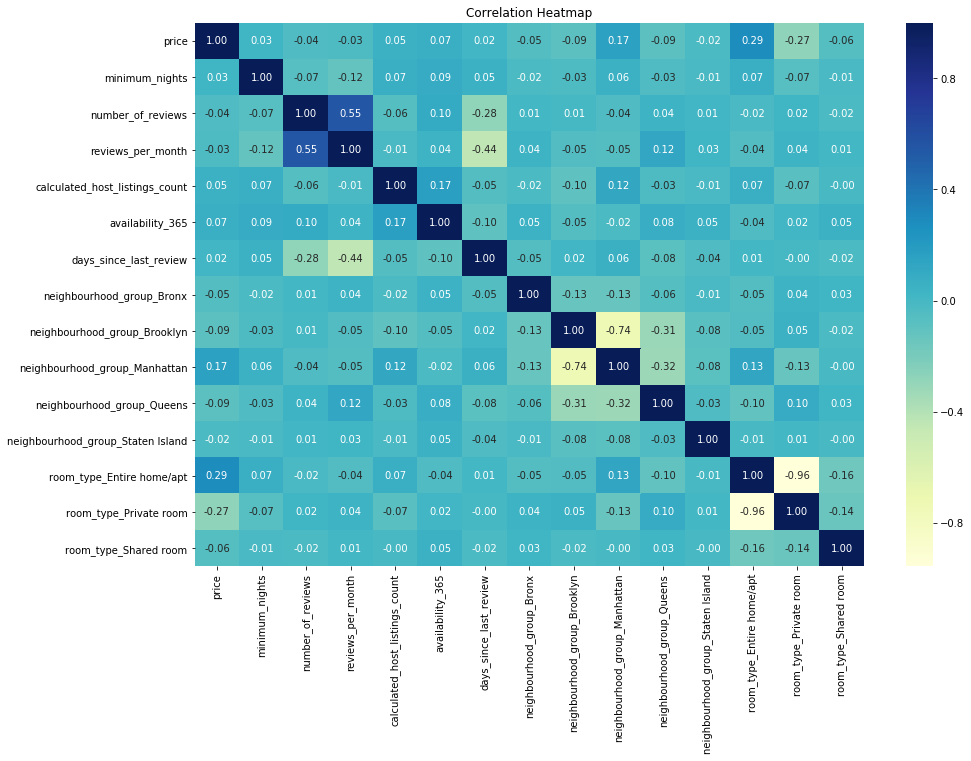

In [37]:
# Feature selection using correlation matrix
plt.figure(figsize=(15,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
sns.heatmap(bnb2.corr(),annot=True, fmt=".2f", cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### **4.3.2 Applying Correlation Rule of Thumb**

In [38]:
minumum_correlation_value_needed = 2/math.sqrt(bnb.shape[0])
print("Minimum correlation value needed to be statistically signficance for this dataset is",minumum_correlation_value_needed)

# Finding data correlation 
corr = bnb2.corr()
print(abs(corr))

Minimum correlation value needed to be statistically signficance for this dataset is 0.010150715051069814
                                      price  minimum_nights  \
price                              1.000000        0.025501   
minimum_nights                     0.025501        1.000000   
number_of_reviews                  0.035924        0.069366   
reviews_per_month                  0.030623        0.121712   
calculated_host_listings_count     0.052895        0.073474   
availability_365                   0.068142        0.094869   
days_since_last_review             0.016843        0.052892   
neighbourhood_group_Bronx          0.048389        0.016912   
neighbourhood_group_Brooklyn       0.090792        0.027061   
neighbourhood_group_Manhattan      0.165766        0.056938   
neighbourhood_group_Queens         0.086335        0.034601   
neighbourhood_group_Staten Island  0.024005        0.012717   
room_type_Entire home/apt          0.287209        0.073259   
room_type_Pr

All columns except calculated_host_listings_count and room_type_Shared room show a significant correlation with the reviews_per_month. We will drop calculated_host_listings_count in the dataset.

In [39]:
bnb1.drop(["calculated_host_listings_count"],axis = 1, inplace = True)
bnb1

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_since_last_review
0,Brooklyn,Private room,149,1,9,0.21,365.000000,414.0
1,Manhattan,Entire home/apt,225,1,45,0.38,355.000000,200.0
3,Brooklyn,Entire home/apt,89,1,270,4.64,194.000000,155.0
4,Manhattan,Entire home/apt,80,10,9,0.10,114.886299,383.0
5,Manhattan,Entire home/apt,200,3,74,0.59,129.000000,168.0
...,...,...,...,...,...,...,...,...
48782,Manhattan,Private room,129,1,1,1.00,147.000000,153.0
48790,Queens,Private room,45,1,1,1.00,339.000000,153.0
48799,Staten Island,Private room,235,1,1,1.00,87.000000,153.0
48805,Bronx,Entire home/apt,100,1,2,2.00,40.000000,153.0


## **4.4 Standardize dataset**

In [40]:
scaler  = MinMaxScaler()
bnb2['price'] = scaler.fit_transform( bnb1['price'].values.reshape(-1, 1))
bnb2['minimum_nights'] = scaler.fit_transform( bnb1['minimum_nights'].values.reshape(-1, 1))
bnb2['availability_365'] = scaler.fit_transform( bnb1['availability_365'].values.reshape(-1, 1))
bnb2['days_since_last_review'] = scaler.fit_transform( bnb1['days_since_last_review'].values.reshape(-1, 1))

## **4.5 Preparing X and y**

In [41]:
bnb_features = ["price", "minimum_nights", "availability_365", "days_since_last_review", "neighbourhood_group_Bronx", "neighbourhood_group_Brooklyn", "neighbourhood_group_Manhattan", "neighbourhood_group_Queens", "neighbourhood_group_Staten Island", "room_type_Entire home/apt", "room_type_Private room"]
reviews_per_month = ["reviews_per_month"]

X = bnb2[bnb_features].to_numpy()
y = bnb1[reviews_per_month].to_numpy().ravel()

print(X.shape)
print(y.shape)

(38821, 11)
(38821,)


# **5. Model Building**

In [42]:
# Splitting the dataset into training and testing data 
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.2, random_state = 2)

print("x_train = " , X_train.shape)
print("y_train = " , y_train.shape)
print("x_validate = " , X_validate.shape)
print("y_validate = " , y_validate.shape)

x_train =  (31056, 11)
y_train =  (31056,)
x_validate =  (7765, 11)
y_validate =  (7765,)


## **5.1 Baseline model construction**

Intuitively, price has a very high correlation with the number of bookings. Therefore, we would like to construct  a baseline model which runs a linear regression with the price attribute only.

In [43]:
baseline_features = ['price']

baseline_X = bnb2[baseline_features]
baseline_y = bnb1[reviews_per_month]

baseline_X_train, baseline_X_validate, baseline_y_train, baseline_y_validate = train_test_split(baseline_X, baseline_y, test_size = 0.2, random_state = 2)

model_linear = LinearRegression()
linear = model_linear.fit(baseline_X_train, baseline_y_train)
baseline_y_pred = linear.predict(baseline_X_train)
baseline_mse = metrics.mean_squared_error(baseline_y_train,baseline_y_pred)
baseline_rmse = np.sqrt(baseline_mse)

print ("The root-mean-square error for the baseline model is",baseline_rmse)

The root-mean-square error for the baseline model is 1.694940515828504


## **5.2 Model Building and Evaluation**

## **5.2.1 Preliminary**

In this section, there are five models as our choices for the analysis.
    1. Linear regression
    2. Ridge model
    3. Lasso model
    4. Bayesian Ridge model
    5. Gradient Boost Regressor
    
In order to get the most accurate result, we will first fit our training dataset and testing dataset into each model. After that, we will test the root-mean-square error of the models and pick the one with the lowest RMSE value. We will run cross validation in each of the model to obtain the optimized parameters for performance benchmarking.

## **5.2.2 Linear Regression**

The root-mean-square error of linear regression after fitting in the training dataset and the testing dataset.

In [44]:
# LinearRegression
linear_rmse = 0

def rmse_linear(trainingX, trainingY, validationX, validationY):
    total = 0
    kf = KFold(n_splits=3)
    kf.get_n_splits(trainingX)
    for train_index, validate_index in kf.split(trainingX):
        x_train, x_validate = trainingX[train_index], trainingX[validate_index]
        y_train, y_validate = trainingY[train_index], trainingY[validate_index]
        linear = LinearRegression()
        linear.fit(trainingX, trainingY)
        predictionL = linear.predict(validationX)
        mse = mean_squared_error(validationY,predictionL)
        rmse = sqrt(mse)
    total+= rmse
    avg= rmse/3
    return avg

def linear_main():
    global linear_rmse
    # Splitting the dataset into training and testing data 
    x_fulltrain, x_test,y_fulltrain, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # Training and validation sets within the training set
    x_train, x_validate,y_train, y_validate = train_test_split(x_fulltrain, y_fulltrain, test_size = 0.2, random_state=42)
    print("x full training set = " , x_fulltrain.shape)
    print("x full testing = " , x_test.shape)
    print("x training subset", x_train.shape)
    print("x validate subset", x_validate.shape)
    
    # Using the best parameter found
    linear = LinearRegression()
    linear.fit(x_fulltrain, y_fulltrain)
    predictionL = linear.predict(x_test)
    mse = mean_squared_error(y_test, predictionL)
    linear_rmse = sqrt(mse)
    print("The root-mean-square error of linear regression is", linear_rmse)
  
linear_main()

x full training set =  (31056, 11)
x full testing =  (7765, 11)
x training subset (24844, 11)
x validate subset (6212, 11)
The root-mean-square error of linear regression is 1.4429067023857058


## **5.2.3 Ridge**

The root-mean-square error of Ridge model after fitting in the training dataset and the testing dataset.

In [45]:
# Ridge
ridge_rmse = 0

# Range of alpha to test
alphas=np.arange(1,100000,100)

# Function to get the best alpha
def get_best_alpha(trainingX, trainingY, validationX, validationY ):    
    best_a = 0
    best_rmse = float('inf')
    for a in alphas:
        current_rmse = rmse_ridge(trainingX, trainingY, validationX, validationY, a) #training parameter 'test' on validate set 
        average_rmse = current_rmse;
        if average_rmse < best_rmse:
            best_rmse = average_rmse
            best_a = a
    print("Best alpha is " + str(best_a))
    print("Best RMSE is "+ str(average_rmse))
    return best_a

def rmse_ridge(trainingX, trainingY, validationX, validationY, a):
    total = 0
    kf = KFold(n_splits=3)
    kf.get_n_splits(trainingX)
    for train_index, validate_index in kf.split(trainingX):
        x_train, x_validate = trainingX[train_index], trainingX[validate_index]
        y_train, y_validate = trainingY[train_index], trainingY[validate_index]
        ridge = Ridge(alpha=a)
        ridge.fit(trainingX, trainingY)
        predictionL = ridge.predict(validationX)
        mse = mean_squared_error(validationY,predictionL)
        rmse = sqrt(mse)
    total+= rmse
    avg= rmse/3
    return avg

def ridge_main():
    global ridge_rmse
    # Splitting the dataset into training and testing data 
    x_fulltrain, x_test,y_fulltrain, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # Training and validation sets within the training set
    x_train, x_validate,y_train, y_validate = train_test_split(x_fulltrain, y_fulltrain, test_size = 0.2, random_state=42)
    print("x full training set = " , x_fulltrain.shape)
    print("x full testing = " , x_test.shape)
    print("x training subset", x_train.shape)
    print("x validate subset", x_validate.shape)
    alpha= get_best_alpha(x_train, y_train, x_validate, y_validate)
    
    # Using the best parameter found
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_fulltrain, y_fulltrain)
    predictionL = ridge.predict(x_test)
    mse = mean_squared_error(y_test, predictionL)
    ridge_rmse = sqrt(mse)
    print("The root-mean-square error of ridge is", ridge_rmse)
  
ridge_main()

x full training set =  (31056, 11)
x full testing =  (7765, 11)
x training subset (24844, 11)
x validate subset (6212, 11)
Best alpha is 1
Best RMSE is 0.5520821057884931
The root-mean-square error of ridge is 1.4438425084905289


## **5.2.4 Lasso**

The root-mean-square error of Lasso model after fitting in the training dataset and the testing dataset.

In [46]:
# Lasso
lasso_rmse = 0

# Range of alpha to test
alphas=np.arange(0.01,10,0.005)

# Function to get the best alpha
def get_best_alpha(trainingX, trainingY, validationX, validationY ):    
    best_a = 0
    best_rmse = float('inf')
    for a in alphas:
        current_rmse = rmse_lasso(trainingX, trainingY, validationX, validationY, a) #training parameter 'test' on validate set 
        average_rmse = current_rmse;
        if average_rmse < best_rmse:
            best_rmse = average_rmse
            best_a = a
    print("Best alpha is " + str(best_a))
    print("Best RMSE is "+ str(average_rmse))
    return best_a

def rmse_lasso(trainingX, trainingY, validationX, validationY, a):
    total = 0
    kf = KFold(n_splits=3)
    kf.get_n_splits(trainingX)
    for train_index, validate_index in kf.split(trainingX):
        x_train, x_validate = trainingX[train_index], trainingX[validate_index]
        y_train, y_validate = trainingY[train_index], trainingY[validate_index]
        lasso = Lasso(alpha=a)
        lasso.fit(trainingX, trainingY)
        predictionL = lasso.predict(validationX)
        mse = mean_squared_error(validationY,predictionL)
        rmse = sqrt(mse)
    total+= rmse
    avg= rmse/3
    return avg

def lasso_main():
    global lasso_rmse
    # Splitting the dataset into training and testing data 
    x_fulltrain, x_test,y_fulltrain, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # Training and validation sets within the training set
    x_train, x_validate,y_train, y_validate = train_test_split(x_fulltrain, y_fulltrain, test_size = 0.2, random_state=42)
    print("x full training set = " , x_fulltrain.shape)
    print("x full testing = " , x_test.shape)
    print("x training subset", x_train.shape)
    print("x validate subset", x_validate.shape)
    alpha= get_best_alpha(x_train, y_train, x_validate, y_validate)
    
    # Using the best parameter found
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_fulltrain, y_fulltrain)
    predictionL = lasso.predict(x_test)
    mse = mean_squared_error(y_test, predictionL)
    lasso_rmse = sqrt(mse)
    print("The root-mean-square error of lasso is", lasso_rmse)
  
lasso_main()

x full training set =  (31056, 11)
x full testing =  (7765, 11)
x training subset (24844, 11)
x validate subset (6212, 11)
Best alpha is 0.01
Best RMSE is 0.5530160652943371
The root-mean-square error of lasso is 1.4571036784354705


## **5.2.5 Bayesian Ridge**

The root-mean-square error of Bayesian Ridge model after fitting in the training dataset and the testing dataset.

In [47]:
# BayesianRidge
bayesian_rmse = 0

def rmse_bayesian(trainingX, trainingY, validationX, validationY):
    total = 0
    kf = KFold(n_splits=3)
    kf.get_n_splits(trainingX)
    for train_index, validate_index in kf.split(trainingX):
        x_train, x_validate = trainingX[train_index], trainingX[validate_index]
        y_train, y_validate = trainingY[train_index], trainingY[validate_index]
        bayesian = BayesianRidge()
        bayesian.fit(trainingX, trainingY)
        predictionL = bayesian.predict(validationX)
        mse = mean_squared_error(validationY,predictionL)
        rmse = sqrt(mse)
    total+= rmse
    avg= rmse/3
    return avg

def bayesian_main():
    global bayesian_rmse
    # Splitting the dataset into training and testing data 
    x_fulltrain, x_test,y_fulltrain, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # Training and validation sets within the training set
    x_train, x_validate,y_train, y_validate = train_test_split(x_fulltrain, y_fulltrain, test_size = 0.2, random_state=42)
    print("x full training set = " , x_fulltrain.shape)
    print("x full testing = " , x_test.shape)
    print("x training subset", x_train.shape)
    print("x validate subset", x_validate.shape)
    
    # Using the best parameter found
    bayesian = BayesianRidge()
    bayesian.fit(x_fulltrain, y_fulltrain)
    predictionL = bayesian.predict(x_test)
    mse = mean_squared_error(y_test, predictionL)
    bayesian_rmse = sqrt(mse)
    print("The root-mean-square error of bayesian ridge is", bayesian_rmse)
  
bayesian_main()

x full training set =  (31056, 11)
x full testing =  (7765, 11)
x training subset (24844, 11)
x validate subset (6212, 11)
The root-mean-square error of bayesian ridge is 1.4430747477546308


## **5.2.6 Gradient Boosting Regressor**

The root-mean-square error of Gradient Boosting Regressor model after fitting in the training dataset and the testing dataset.

In [48]:
# GradientBoostingRegressor
gbr_rmse = 0
gbr = None

# Range of alpha to test
alphas=np.arange(0.01,0.99,0.05)

# Function to get the best alpha
def get_best_alpha(trainingX, trainingY, validationX, validationY ):    
    best_a = 0
    best_rmse = float('inf')
    for a in alphas:
        current_rmse = rmse_gbr(trainingX, trainingY, validationX, validationY, a) #training parameter 'test' on validate set 
        average_rmse = current_rmse;
        if average_rmse < best_rmse:
            best_rmse = average_rmse
            best_a = a
    print("Best alpha is " + str(best_a))
    print("Best RMSE is "+ str(average_rmse))
    return best_a

def rmse_gbr(trainingX, trainingY, validationX, validationY, a):
    total = 0
    kf = KFold(n_splits=3)
    kf.get_n_splits(trainingX)
    for train_index, validate_index in kf.split(trainingX):
        x_train, x_validate = trainingX[train_index], trainingX[validate_index]
        y_train, y_validate = trainingY[train_index], trainingY[validate_index]
        gbr = GradientBoostingRegressor(alpha=a, n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
        gbr.fit(trainingX, trainingY)
        predictionL = gbr.predict(validationX)
        mse = mean_squared_error(validationY,predictionL)
        rmse = sqrt(mse)
    total+= rmse
    avg= rmse/3
    return avg

def gbr_main():
    global gbr_rmse
    global gbr
    # Splitting the dataset into training and testing data 
    x_fulltrain, x_test,y_fulltrain, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # Training and validation sets within the training set
    x_train, x_validate,y_train, y_validate = train_test_split(x_fulltrain, y_fulltrain, test_size = 0.2, random_state=42)
    print("x full training set = " , x_fulltrain.shape)
    print("x full testing = " , x_test.shape)
    print("x training subset", x_train.shape)
    print("x validate subset", x_validate.shape)
    alpha= get_best_alpha(x_train, y_train, x_validate, y_validate)
    
    # Using the best parameter found
    gbr = GradientBoostingRegressor(alpha=alpha, n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    gbr.fit(x_fulltrain, y_fulltrain)
    predictionL = gbr.predict(x_test)
    mse = mean_squared_error(y_test, predictionL)
    gbr_rmse = sqrt(mse)
    print("The root-mean-square error of gradient boosting regressor is", gbr_rmse)
  
gbr_main()

x full training set =  (31056, 11)
x full testing =  (7765, 11)
x training subset (24844, 11)
x validate subset (6212, 11)
Best alpha is 0.01
Best RMSE is 0.3983043409788077
The root-mean-square error of gradient boosting regressor is 1.1692725300593805


## **5.3 Results**

All of the aforementioned models has a lower RMSE than the baseline model and are considered better. After a series of calculation, we can find the desired model for analysis.

In [49]:
rmse = {"Linear Regression":linear_rmse,"Ridge Regression":ridge_rmse,"Lasso Regression":lasso_rmse,"Bayesianridge Regression":bayesian_rmse,"Gradient Boosting Regressor":gbr_rmse}
min_value = min(rmse.values())
min_keys = [k for k, v in rmse.items() if v == min_value]
print("")
print(min_keys[0],"has the lowest root-mean-square error of", min_value)


Gradient Boosting Regressor has the lowest root-mean-square error of 1.1692725300593805


As a result, **Gradient Boosting Regressor** will be used for prediction analysis.

## **5.4 Exploratory Data Analysis (EDA) after data construction**

### **5.4.1 Scatter graph showing relationship between days since last review and reviews per month**

Text(0.5, 1.0, 'Relationship between days_since_last_review and reviews_per_month')

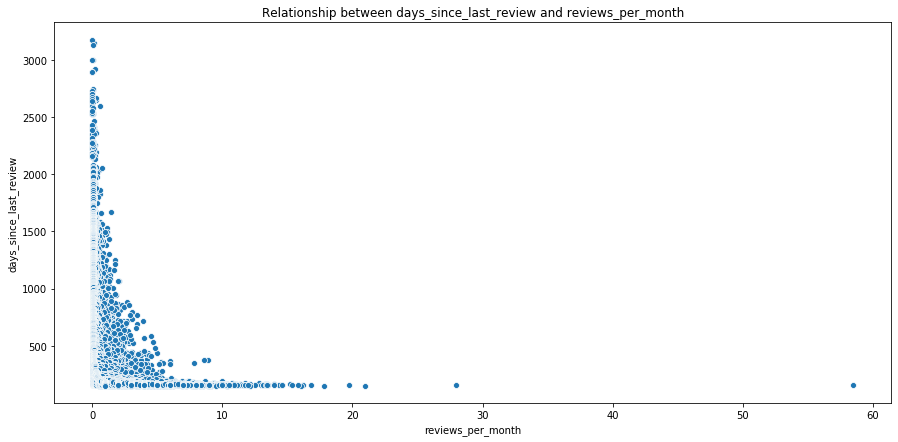

In [50]:
plt.subplots(figsize=(15,7))
sns.scatterplot(x=bnb1["reviews_per_month"], y=bnb1["days_since_last_review"], data=bnb)
plt.title("Relationship between days_since_last_review and reviews_per_month")

From the graph, we can see a **negative relationship** between reviews_per_month and days_since_last_review, which means the higher the days since last review, the lower the reviews per month.

### **5.4.2 Horizontal bar chart showing the relationship between room type and total reviews per month**

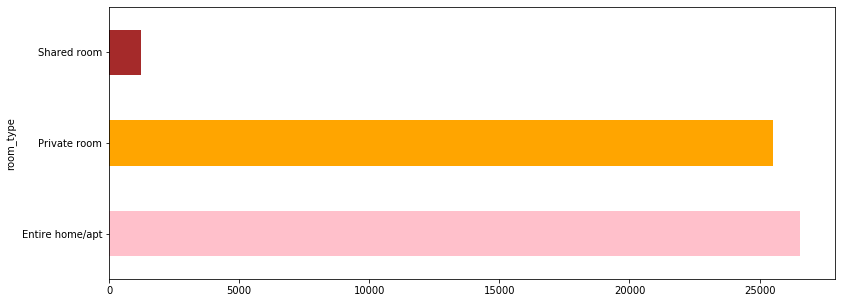

In [51]:
bnb_graph = bnb1.groupby(['room_type'])['reviews_per_month'].sum()
plt.subplots(figsize=(13,5))
bnb_graph.plot(kind="barh",color=['pink', 'orange', 'brown'])

From the graph, we can see that entire home/apartment and private room have a lot more reviews than shared room in the dataset, which means shared room has the least number of booking based on our prediction formula.

### **5.4.3 Scatterplot showing relationship of price and reviews_per_month**

Text(0.5, 1.0, 'Relationship between price and reviews_per_month')

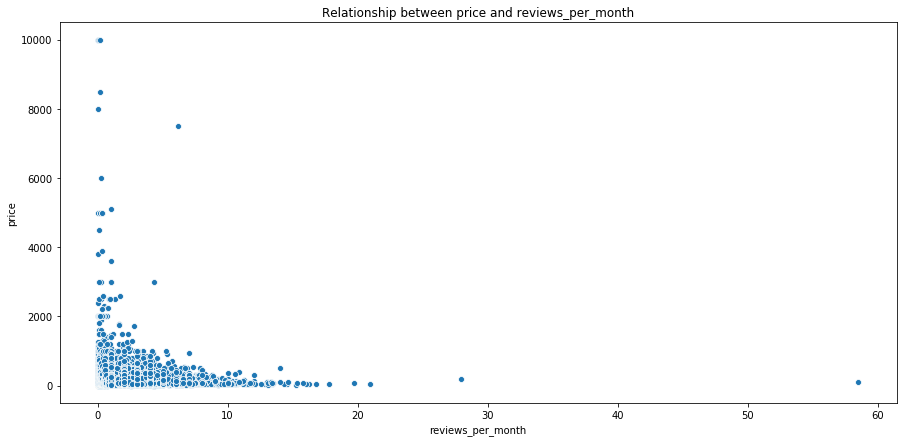

In [52]:
plt.subplots(figsize=(15,7))
sns.scatterplot(x=bnb1["reviews_per_month"], y=bnb1["price"], data=bnb)
plt.title("Relationship between price and reviews_per_month")

From the graph, we can see a *negative relationship* between reviews_per_month and price, implicating that the higher the price the lower the reviews per month.

# **6. Model Testing**

## **6.1 Test the model**

In [53]:
Y_Predict = gbr.predict(X_validate)
print('The following are the predicted results of the Testing Dataset')
Y_Predict

The following are the predicted results of the Testing Dataset


array([ 2.95669827, -0.64256538, -0.03358568, ...,  0.65188971,
        0.04358089,  0.84542274])

In [54]:
# Finish Timer
print("---- The Workbook is completed in %s seconds / %s minutes----" \
                 %((str(round((time.time() - Start_time),4))),(str(round(((time.time() - Start_time))/60,4)))))

---- The Workbook is completed in 139.7344 seconds / 2.3289 minutes----


## **6.2 Converting reviews_per_month to projected number of booking**

With the capability of predicting reviews per month, we can provide recommendations to Airbnb hosts to find their potential booking value. According to the research found from Insideairbnb, we derived the formula projected annual number of booking = (reviews per month * 12) / 0.5. 

    Illustration: 
        - Charles Airbnb has a predictied reviews per month = 10, so Charles's listing has a predicted booking rate for the year is (10*12)/0.5 = 240. Implying around 20 bookings per month. 

The statistics can serve as a key performance indicator (KPI) for airbnb hosts to manage their listings and think of strategies to improve their performance.

# **7. Conclusion**

Our goal in the beginning was to **determine the popularity of an Airbnb listing**. We defined **popularity** as the **projected annual number of bookings**, which is calculated based on a formula revolving around **reviews per month**. We analyzed the remaining 8 features (name, neighbourhood group, room type, price, minimum nights, number of reviews, calculated host listings count and availability 365), performed **one-hot encoding** on categorical variables, and derived a **correlation table** in order to identify attributes with relevant impact on the listing popularity. After standardizing, we split the dataset into training and testing data. We built models including **linear regression** for simplicity, **ridge** for speed, **lasso** for sparsity, **bayesian ridge** to achieve maximum likelihood and **gradient boosting regressor** that allows for the optimization of arbitrary differentiable loss functions. Our group also considered **model enhancement strategies**, we believe other data mining strategies such has **text mining** using spacy and scattertext can be incorporated in the future. Sentiment analysis can further draw conclusions on the listing name to advice hosts to rephrase and boost their listing attractiveness.  

In addition to the numerical prediction of booking rates, we have conducted **exploratory data analysis** that concludes correlations and trends that advices Airbnb hosts to **improve their listing popularity and profitability**. We found that attribute **day_since_last_review** has a **strong negative correlation** with reviews_per_month. This explains the **recency** of booking is a **crucial factor** for travellers. As mentioned in the above section, other trends such as **price** and **room type** also influences the traveller’s booking decision. By having a comprehensive understanding of listing attributes, Airbnb hosts can effectively **pinpoint their weaknesses and improve**. 